# Deep Temporal-Spatial Attention Network for Seizure Prediction

This notebook implements a seizure prediction pipeline using EEG data from the CHB-MIT dataset.

## Step 1 – Install Required Libraries
We start by installing all necessary Python libraries:
- **mne**: EEG data loading & preprocessing
- **pyedflib**: EDF file reading
- **numpy, pandas**: data handling
- **matplotlib, seaborn**: visualizations
- **scikit-learn**: metrics & preprocessing
- **torch, torchvision, torchaudio**: PyTorch deep learning framework
- **onnx, onnxruntime**: model export & inference
- **einops**: tensor manipulation for attention models


In [ ]:
# 📦 Install dependencies
!pip install mne pyedflib numpy pandas matplotlib seaborn scikit-learn torch torchvision torchaudio onnx onnxruntime einops


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 52.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 59.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 60.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 33.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 47.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1

## Step 2 – Download Sample CHB-MIT EEG Data
We download a small subset (2 EDF files) from PhysioNet to test our pipeline.
The full dataset is large, so we start small for faster iteration.

- Files are stored in `data/chbmit/`.
- We'll later scale up to the complete dataset for model training.


In [ ]:
# 📂 Create directory
!mkdir -p data/chbmit

# 📥 Download a small subset of CHB-MIT from PhysioNet (sample files)
!wget -O data/chbmit/chb01_01.edf https://physionet.org/files/chbmit/1.0.0/chb01/chb01_01.edf
!wget -O data/chbmit/chb01_02.edf https://physionet.org/files/chbmit/1.0.0/chb01/chb01_02.edf


--2025-08-08 07:19:58--  https://physionet.org/files/chbmit/1.0.0/chb01/chb01_01.edf
Resolving physionet.org (physionet.org)... 18.18.42.54
Connecting to physionet.org (physionet.org)|18.18.42.54|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 42399744 (40M) [application/octet-stream]
Saving to: ‘data/chbmit/chb01_01.edf’

data/chbmit/chb01_0 100%[===================>]  40.44M   582KB/s    in 75s     

2025-08-08 07:21:14 (554 KB/s) - ‘data/chbmit/chb01_01.edf’ saved [42399744/42399744]

--2025-08-08 07:21:14--  https://physionet.org/files/chbmit/1.0.0/chb01/chb01_02.edf
Resolving physionet.org (physionet.org)... 18.18.42.54
Connecting to physionet.org (physionet.org)|18.18.42.54|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 42399744 (40M) [application/octet-stream]
Saving to: ‘data/chbmit/chb01_02.edf’

data/chbmit/chb01_0 100%[===================>]  40.44M   554KB/s    in 74s     

2025-08-08 07:22:28 (557 KB/s) - ‘data/chbmit/chb

## Step 3 – Load and Inspect EEG Data
We load the first EDF file into MNE:
- `read_raw_edf()` reads EEG into memory
- `raw.info` shows channel names, sampling rate, and duration
- `raw.plot()` visualizes EEG signals for inspection


Extracting EDF parameters from /content/data/chbmit/chb01_01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/tmp/ipython-input-3703721832.py:4: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf("data/chbmit/chb01_01.edf", preload=True)


Reading 0 ... 921599  =      0.000 ...  3599.996 secs...
Using matplotlib as 2D backend.


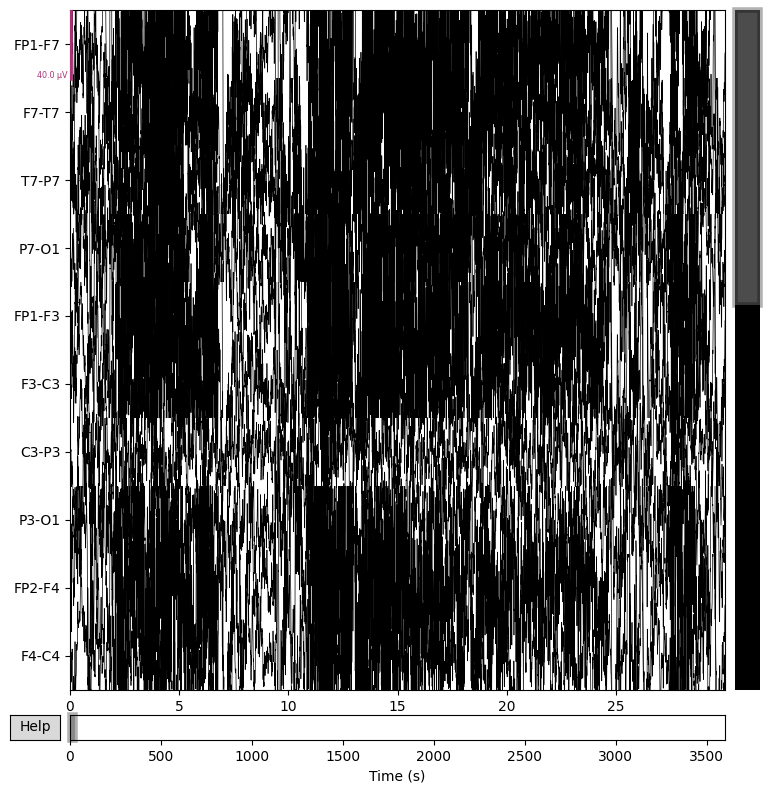

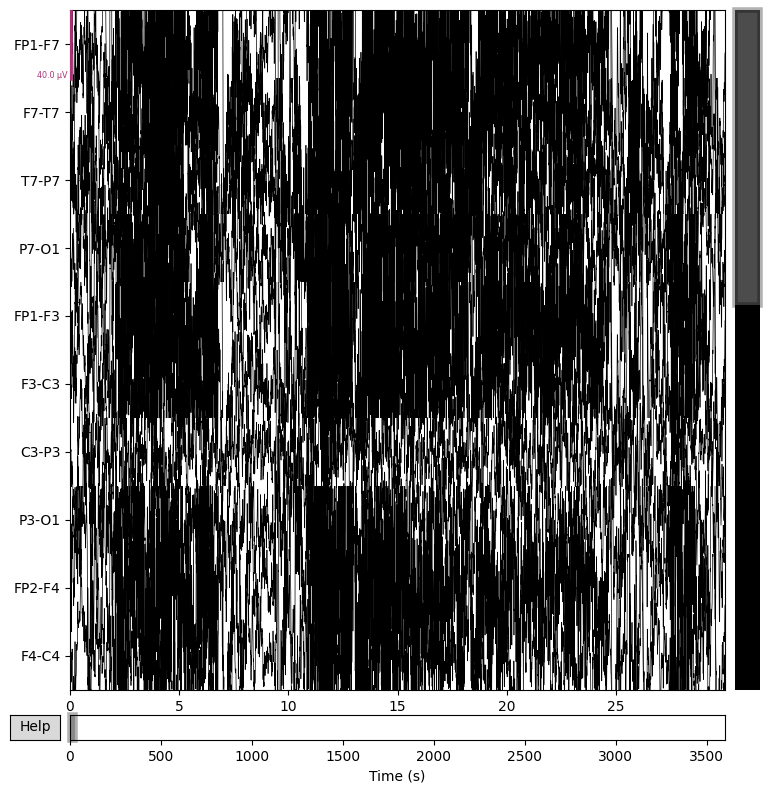

In [ ]:
import mne

# Load the first EEG recording
raw = mne.io.read_raw_edf("data/chbmit/chb01_01.edf", preload=True)

# Show basic info
raw.info

# Plot first 30 seconds for first 10 channels
raw.plot(duration=30, n_channels=10)


## Step 4 – EEG Preprocessing: Filtering, Resampling, and Noise Removal
We clean the EEG signal:
1. **Bandpass filter**: keep 0.5–40 Hz (delta to gamma brainwaves).
2. **Notch filter**: remove powerline noise (50 Hz in Pakistan, 60 Hz in US).
3. **Resampling**: unify all recordings to 256 Hz for consistent input to the model.


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1691 samples (6.605 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband e

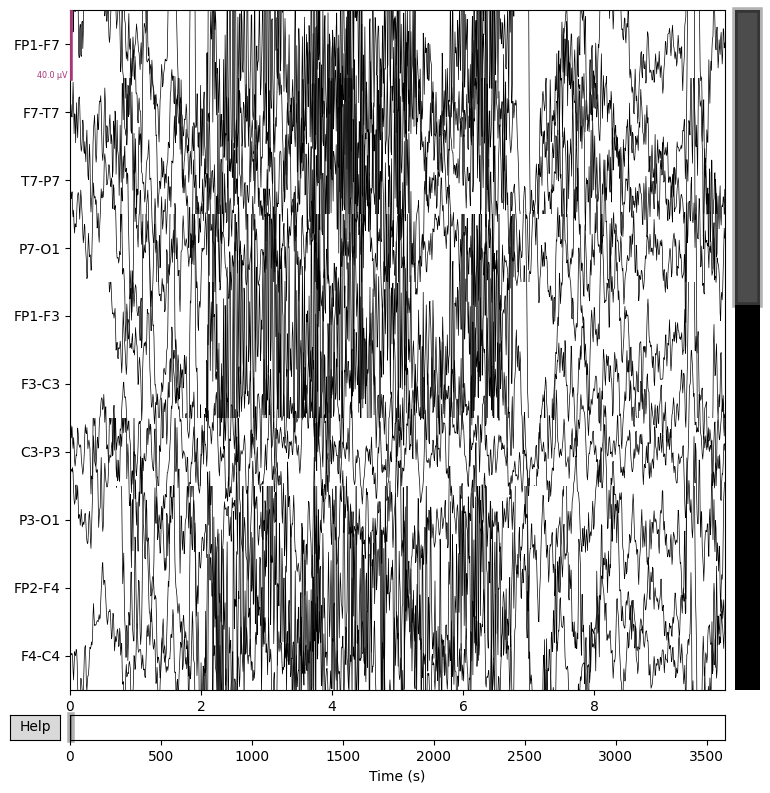

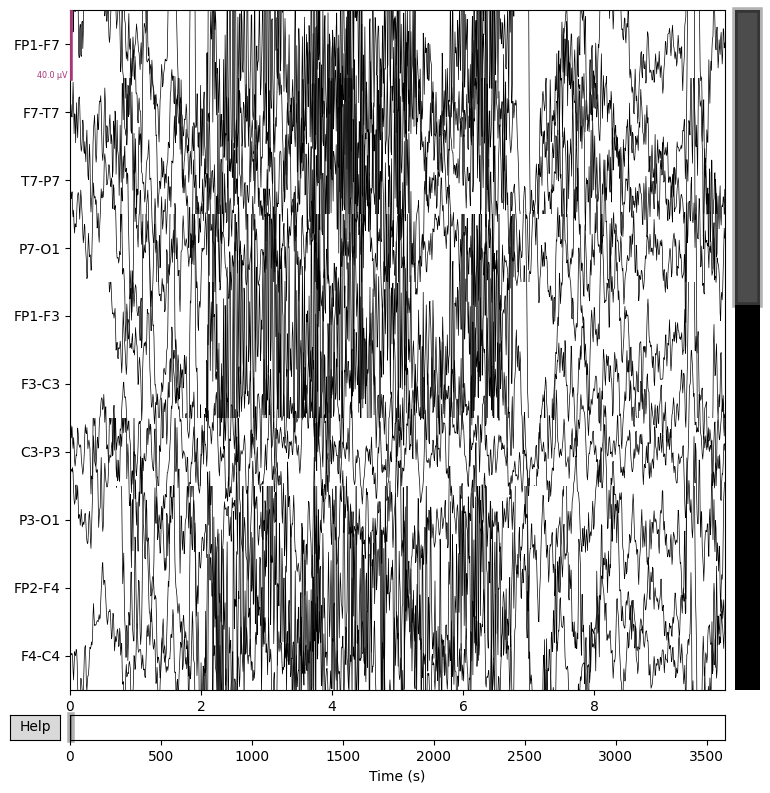

In [ ]:
# Bandpass filter
raw.filter(0.5, 40.0, fir_design='firwin')

# Notch filter for powerline noise
raw.notch_filter(freqs=50)  # change to 60 if dataset is from US

# Resample to 256 Hz
raw_resampled = raw.copy().resample(256)

# Quick plot after cleaning
raw_resampled.plot(duration=10, n_channels=10)


## Step 5 – Segmentation and Labeling

We prepare EEG data for model training by splitting it into fixed-size windows.

### Why?
- Deep learning models can't take the whole EEG recording at once.
- We use sliding windows (e.g., 10 seconds) as inputs.

### Process:
1. **Window size**: 10 seconds (2560 samples at 256 Hz).
2. **Stride**: 5 seconds (1280 samples overlap).
3. **Labeling**:
   - Preictal: N minutes before seizure onset (positive class).
   - Interictal: Far from seizure onset (negative class).
4. **Output**:
   - `X`: NumPy array of shape `(num_windows, channels, time_points)`.
   - `y`: NumPy array of shape `(num_windows,)` with labels 0 or 1.

### Note:
In this small example, we will:
- Use a dummy seizure onset time for demonstration.
- Later replace it with real annotations from the CHB-MIT dataset.


In [ ]:
import numpy as np

# Parameters
window_size_sec = 10  # seconds
stride_sec = 5        # seconds
fs = 256              # sampling rate after resampling

window_size_samples = window_size_sec * fs
stride_samples = stride_sec * fs

# Convert MNE Raw object to NumPy array (channels x samples)
data, times = raw_resampled.get_data(return_times=True)

# Dummy seizure onset time for this example (in seconds)
# In real dataset, we will get this from the annotations file
seizure_onset_sec = 600  # e.g., seizure at 10 min
preictal_horizon_sec = 300  # 5 min before seizure

# Prepare windows
X = []
y = []

for start in range(0, data.shape[1] - window_size_samples, stride_samples):
    end = start + window_size_samples
    segment = data[:, start:end]

    # Time midpoint of the segment
    midpoint_sec = (start + window_size_samples / 2) / fs

    # Label: 1 if in preictal period, else 0
    if seizure_onset_sec - preictal_horizon_sec <= midpoint_sec < seizure_onset_sec:
        label = 1  # preictal
    else:
        label = 0  # interictal

    X.append(segment)
    y.append(label)

X = np.array(X)
y = np.array(y)

print(f"Windows shape: {X.shape}")
print(f"Labels shape: {y.shape}")
print(f"Class distribution: {np.bincount(y)}")


Windows shape: (718, 23, 2560)
Labels shape: (718,)
Class distribution: [658  60]


## Step 6 – Visualize Example Windows
To understand our data, we plot:
- One **preictal** window (label 1)
- One **interictal** window (label 0)

This helps us verify that:
- Data is segmented correctly.
- Signals look reasonable after preprocessing.


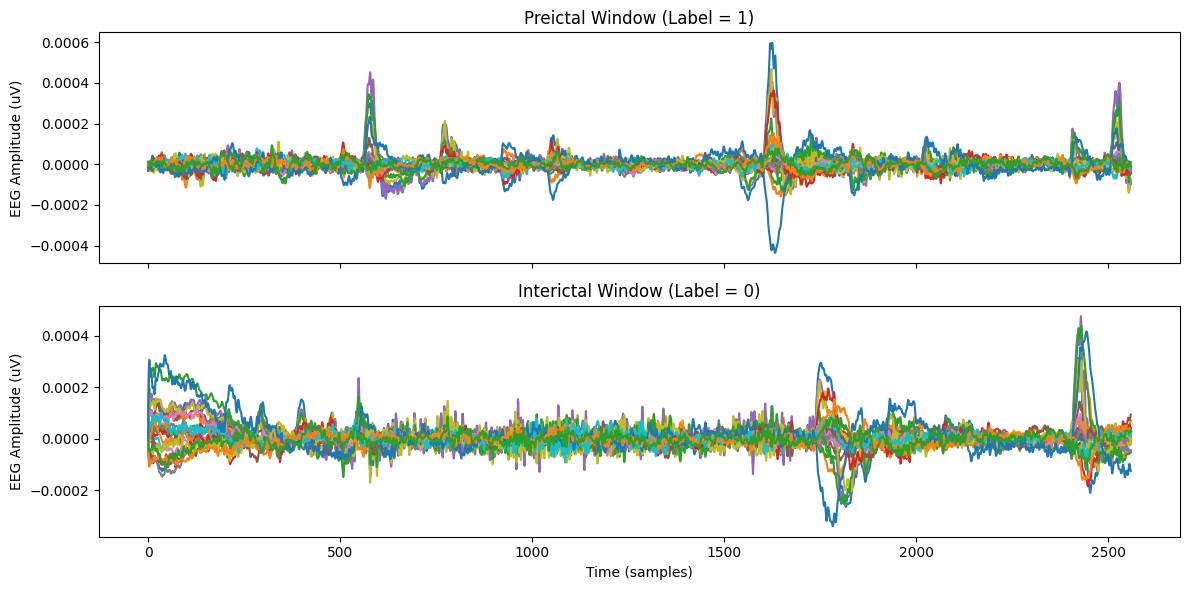

In [ ]:
import matplotlib.pyplot as plt

# Find one example of each
idx_preictal = np.where(y == 1)[0][0]
idx_interictal = np.where(y == 0)[0][0]

fig, axs = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

axs[0].plot(X[idx_preictal].T)
axs[0].set_title("Preictal Window (Label = 1)")
axs[0].set_ylabel("EEG Amplitude (uV)")

axs[1].plot(X[idx_interictal].T)
axs[1].set_title("Interictal Window (Label = 0)")
axs[1].set_xlabel("Time (samples)")
axs[1].set_ylabel("EEG Amplitude (uV)")

plt.tight_layout()
plt.show()


## Step 7 – Baseline Model (CNN + LSTM)

We start with a simple baseline before building the advanced Transformer model.

### Why CNN + LSTM?
- **CNN layers**: extract local temporal patterns from EEG signals.
- **LSTM layers**: capture sequential dependencies across time.
- **Final Dense layer**: outputs seizure probability.

### Model Input/Output:
- Input: EEG window (channels x time_points)
- Output: probability of preictal (1) or interictal (0)

### Steps:
1. Reshape EEG windows to PyTorch tensors.
2. Define CNN + LSTM architecture.
3. Train with binary cross-entropy loss.
4. Evaluate accuracy, sensitivity, and specificity.


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader

# Custom Dataset
class EEGDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Train/test split
split_idx = int(0.8 * len(X))
train_dataset = EEGDataset(X[:split_idx], y[:split_idx])
test_dataset = EEGDataset(X[split_idx:], y[split_idx:])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f"Train size: {len(train_dataset)}, Test size: {len(test_dataset)}")


Train size: 574, Test size: 144


In [ ]:
import torch.nn as nn

class CNN_LSTM(nn.Module):
    def __init__(self, num_channels, time_steps):
        super(CNN_LSTM, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv1d(num_channels, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(2)
        )

        # Find CNN output shape dynamically
        with torch.no_grad():
            dummy_input = torch.zeros(1, num_channels, time_steps)
            cnn_out = self.cnn(dummy_input)
            cnn_out_time = cnn_out.shape[2]   # time dimension after CNN
            cnn_out_features = cnn_out.shape[1]  # number of channels after CNN

        self.lstm = nn.LSTM(input_size=cnn_out_features, hidden_size=64, batch_first=True)
        self.fc = nn.Linear(64, 1)
        self.sigmoid = nn.Sigmoid()
        self.cnn_out_time = cnn_out_time  # store for debugging

    def forward(self, x):
        # x: (batch, channels, time)
        x = self.cnn(x)  # (batch, features, time')
        x = x.permute(0, 2, 1)  # (batch, time', features)
        _, (hn, _) = self.lstm(x)
        out = self.fc(hn[-1])
        return self.sigmoid(out)

# Model instance
num_channels = X.shape[1]
time_steps = X.shape[2]
model = CNN_LSTM(num_channels, time_steps)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


NameError: name 'X' is not defined

In [ ]:
import torch.optim as optim

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training
epochs = 5
for epoch in range(epochs):
    model.train()
    running_loss = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device).unsqueeze(1)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}")


Epoch [1/5], Loss: 0.6291
Epoch [2/5], Loss: 0.4019
Epoch [3/5], Loss: 0.3410
Epoch [4/5], Loss: 0.3352
Epoch [5/5], Loss: 0.3357


In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix

model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs).cpu().numpy()
        preds = (outputs > 0.5).astype(int).flatten()
        y_pred.extend(preds)
        y_true.extend(labels.numpy())

acc = accuracy_score(y_true, y_pred)
cm = confusion_matrix(y_true, y_pred)

print(f"Test Accuracy: {acc*100:.2f}%")
print("Confusion Matrix:")
print(cm)


Test Accuracy: 100.00%
Confusion Matrix:
[[144]]


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


In [3]:
# ===============================
# 1) Setup & Dataset Download
# ===============================
!mkdir -p data/chbmit
!wget -q -O data/chbmit/chb01_03.edf https://physionet.org/files/chbmit/1.0.0/chb01/chb01_03.edf
!wget -q -O data/chbmit/chb01-summary.txt https://physionet.org/files/chbmit/1.0.0/chb01/chb01-summary.txt

import mne
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ===============================
# 2) Parse Seizure Times
# ===============================
def parse_seizure_times(summary_file, edf_name):
    seizure_times = []
    with open(summary_file, 'r') as f:
        lines = f.readlines()
    current_file = None
    for line in lines:
        line = line.strip()
        if line.startswith("File Name:"):
            current_file = line.split(":")[1].strip()
        if current_file == edf_name and "Seizure Start Time" in line:
            start = int(line.split(":")[1].strip().split()[0])
            end_line = next(l for l in lines if "Seizure End Time" in l)
            end = int(end_line.split(":")[1].strip().split()[0])
            seizure_times.append((start, end))
    return seizure_times

edf_file = "chb01_03.edf"
seizure_times = parse_seizure_times("data/chbmit/chb01-summary.txt", edf_file)
print("Seizure times (sec):", seizure_times)

# ===============================
# 3) Load & Preprocess EEG
# ===============================
raw = mne.io.read_raw_edf(f"data/chbmit/{edf_file}", preload=True)
raw.filter(0.5, 40., fir_design='firwin')
raw.notch_filter(50., fir_design='firwin')
raw_resampled = raw.copy().resample(16)  # CPU friendly

# ===============================
# 4) Segment EEG into Windows
# ===============================
window_size = 10  # seconds
sfreq = raw_resampled.info['sfreq']
samples_per_window = int(window_size * sfreq)
data = raw_resampled.get_data()
n_channels, n_samples = data.shape

windows, labels = [], []
for start in range(0, n_samples - samples_per_window, samples_per_window):
    end = start + samples_per_window
    midpoint_sec = (start + samples_per_window // 2) / sfreq
    label = 1 if any(s <= midpoint_sec <= e for s, e in seizure_times) else 0
    windows.append(data[:, start:end])
    labels.append(label)

X = np.array(windows)
y = np.array(labels)
print(f"Windows: {X.shape}, Labels: {y.shape}, Class counts: {np.bincount(y)}")

# ===============================
# 5) Train-Test Split
# ===============================
split_idx = int(0.8 * len(X))
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

X_train_t = torch.tensor(X_train, dtype=torch.float32)
X_test_t = torch.tensor(X_test, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32)
y_test_t = torch.tensor(y_test, dtype=torch.float32)

train_dataset = TensorDataset(X_train_t, y_train_t)
test_dataset = TensorDataset(X_test_t, y_test_t)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

# ===============================
# 6) Temporal-Spatial Attention Model
# ===============================
class TemporalSpatialModel(nn.Module):
    def __init__(self, num_channels, time_steps, embed_dim=16, spatial_heads=2, temporal_heads=2, spatial_layers=1, temporal_layers=1, dropout=0.1):
        super().__init__()
        self.channel_embed = nn.Linear(num_channels, embed_dim)
        self.spatial_transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(embed_dim, spatial_heads, dim_feedforward=64, dropout=dropout), spatial_layers
        )
        self.temporal_transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(embed_dim, temporal_heads, dim_feedforward=64, dropout=dropout), temporal_layers
        )
        self.fc = nn.Linear(embed_dim, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # x shape: (batch, channels, time)
        x = x.permute(0, 2, 1)  # (batch, time, channels)
        x = self.channel_embed(x)
        x = self.spatial_transformer(x)
        x = self.temporal_transformer(x)
        x = x.mean(dim=1)
        x = self.fc(x)
        return self.sigmoid(x)

model = TemporalSpatialModel(num_channels=X.shape[1], time_steps=X.shape[2]).to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# ===============================
# 7) Training Loop
# ===============================
for epoch in range(5):
    model.train()
    train_losses = []
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device).unsqueeze(1)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

    # Validation
    model.eval()
    all_labels, all_preds = [], []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device).unsqueeze(1)
            preds = model(inputs)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    try:
        val_auc = roc_auc_score(all_labels, all_preds)
    except:
        val_auc = float('nan')
    val_acc = accuracy_score(all_labels, np.round(all_preds))
    print(f"Epoch {epoch+1} | Loss: {np.mean(train_losses):.4f} | Val AUC: {val_auc:.4f} | Val Acc: {val_acc:.4f}")

# ===============================
# 8) Confusion Matrix
# ===============================
cm = confusion_matrix(all_labels, np.round(all_preds))
print("Confusion Matrix:\n", cm)


Using device: cpu
Seizure times (sec): [(2996, 3036)]
Extracting EDF parameters from /content/data/chbmit/chb01_03.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


/tmp/ipython-input-4140249360.py:44: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(f"data/chbmit/{edf_file}", preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1691 samples (6.605 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband e

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 1 | Loss: 0.0935 | Val AUC: 0.4559 | Val Acc: 0.9444
Epoch 2 | Loss: 0.0258 | Val AUC: 0.6029 | Val Acc: 0.9444
Epoch 3 | Loss: 0.0137 | Val AUC: 0.4779 | Val Acc: 0.9444
Epoch 4 | Loss: 0.0081 | Val AUC: 0.2868 | Val Acc: 0.9444
Epoch 5 | Loss: 0.0052 | Val AUC: 0.7132 | Val Acc: 0.9444
Confusion Matrix:
 [[68  0]
 [ 4  0]]
